<a href="https://colab.research.google.com/github/TanushGoel/Pump-It-Up/blob/master/Pump_It_Up_Water_Catboost_KFolds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
pd.options.mode.use_inf_as_na = False
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# MICE was pretty bad at guessing construction year
train = pd.read_csv('PumpItUpTokenizedCleanedMICE_train.csv')
train.status_group = train.status_group.astype(int)
target = train.status_group
train_id = train.id
train = train.drop('id', axis=1)
train.public_meeting = np.round((train.public_meeting-0.25)).astype(int)
train.permit = np.round((train.permit-0.175)).astype(int)
train.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,6000.0,40616,0,1390,0,34.938093,-9.856322,0,0,0,0,0,11,5,0,0,109,1,0,0,1999.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0.0,41339,1,1399,1,34.698766,-2.147466,1,0,1,1,1,20,2,1,1,280,1,1,1,2010.000000,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,1
2,25.0,41330,2,686,2,37.460664,-3.821329,2,0,2,2,2,21,4,2,2,250,1,0,1,2009.000000,0,0,0,0,0,2,2,0,0,0,0,2,2,1,1,0,1
3,0.0,41302,3,263,3,38.486161,-11.155298,3,0,3,3,3,90,63,3,3,58,1,0,1,1986.000000,1,1,1,0,0,1,1,0,0,2,2,3,3,0,1,0,-1
4,0.0,40737,4,0,4,31.130847,-1.825359,4,0,1,4,4,18,1,4,4,0,1,-1,1,1684.993408,0,0,0,2,1,1,1,0,0,3,3,1,1,1,0,0,1


In [4]:
test = pd.read_csv('PumpItUpTokenizedCleanedMICE_test.csv')
test_id = test.id
test = test.drop('id', axis=1)
test.public_meeting = np.round((test.public_meeting-0.25)).astype(int)
test.permit = np.round((test.permit-0.175)).astype(int)
test.head()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,0.0,41309,162,1996,340,35.290799,-4.059696,37400,0,4,10942,2,21,3,37,573,321,1,8,1,2012.0,5,5,3,8,3,1,1,0,0,3,3,1,1,1,3,2
1,0.0,41309,20,1569,5,36.656709,-3.309214,37401,0,2,19287,16,2,2,26,367,300,1,0,1,2000.0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0
2,0.0,41306,-1,1567,-1,34.767863,-5.004344,21518,0,4,7343,18,13,2,32,647,500,1,0,1,2010.0,5,5,3,0,0,1,1,0,0,1,1,1,1,1,3,2
3,0.0,41296,143,267,129,38.058046,-9.418672,37402,0,3,5578,14,80,43,105,1795,250,1,0,1,1987.0,5,5,3,0,0,3,3,0,0,2,2,5,5,0,3,2
4,500.0,41360,1036,1260,1131,35.006123,-10.950412,2984,0,3,2889,9,10,3,97,653,60,1,4,1,2000.0,0,0,0,4,0,6,6,0,0,0,0,0,0,0,0,0


In [5]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 17.22 MB
Memory usage after optimization is: 3.23 MB
Decreased by 81.2%


In [6]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 4.19 MB
Memory usage after optimization is: 0.79 MB
Decreased by 81.1%


Text(0.5, 1, 'Variable Correlations')

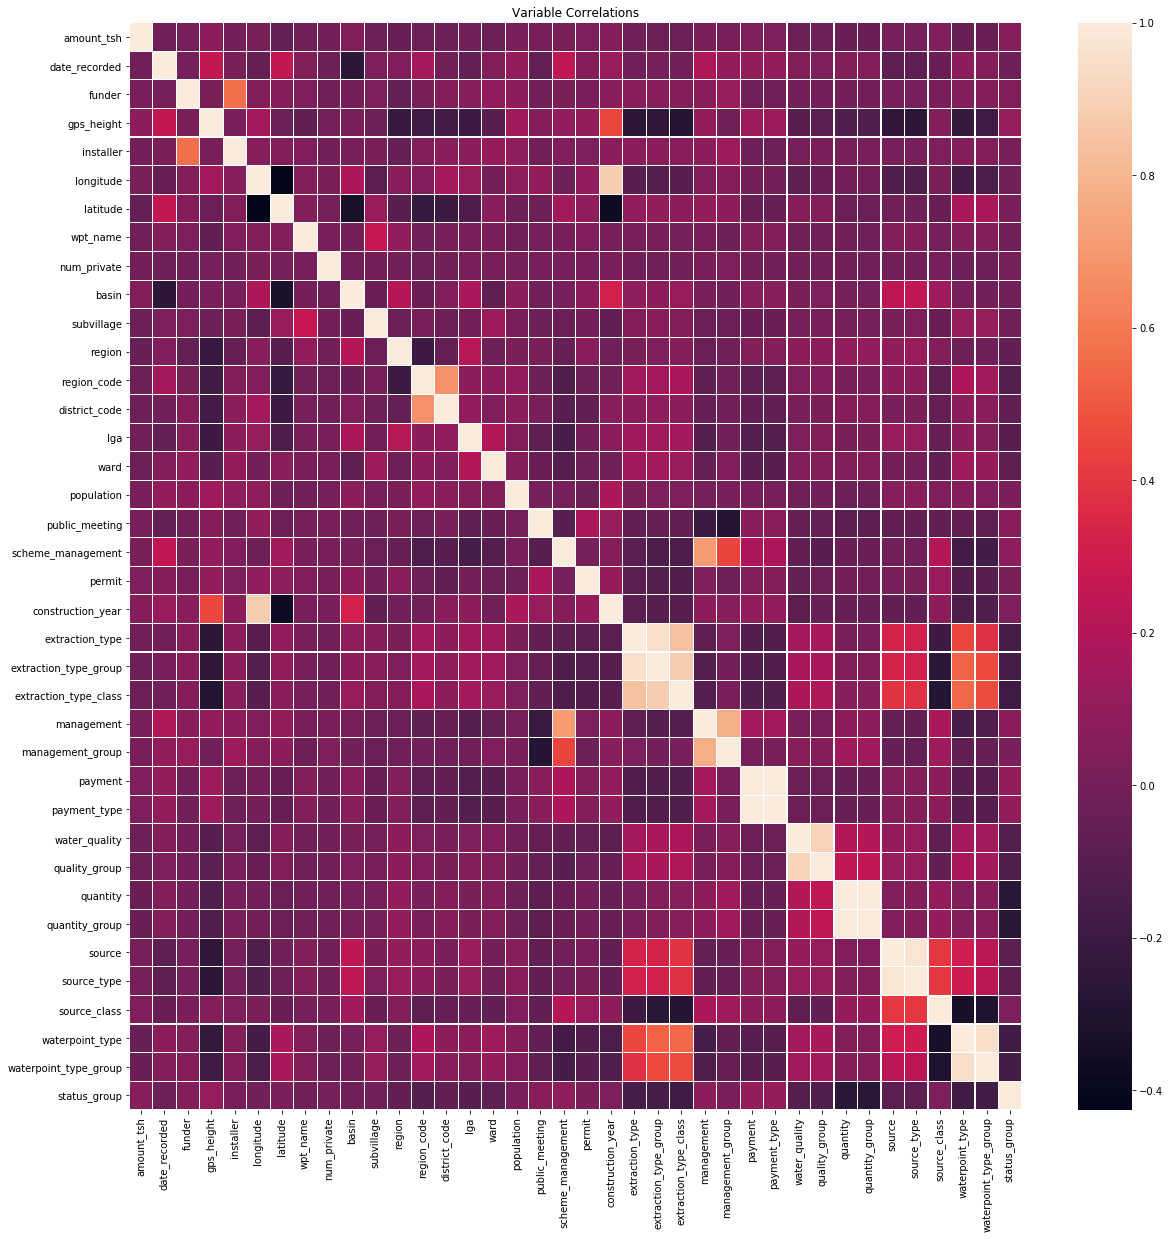

In [7]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(20,20))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [8]:
from sklearn.decomposition import PCA

def principal_component_analyze(df):

    extraction_type = df.extraction_type
    extraction_type_group = df.extraction_type_group
    extraction_type_class = df.extraction_type_class
    
    extraction = pd.DataFrame(data=list(zip(extraction_type, extraction_type_group, extraction_type_class)),
                  columns = ['extraction_type', 'extraction_type_group', 'extraction_type_class'])

    pca_extraction = PCA(n_components=1)
    extractpca = pca_extraction.fit_transform(extraction)
    df['extraction'] = extractpca
    print(pca_extraction.explained_variance_ratio_)
    
    
    management = df.management
    management_group = df.management_group
    
    manage = pd.DataFrame(data=list(zip(management, management_group)),
                  columns = ['management', 'management_group'])

    pca_manage = PCA(n_components=1)
    managementpca = pca_manage.fit_transform(manage)
    df['manage'] = managementpca
    print(pca_manage.explained_variance_ratio_)
    
    
    payment = df.payment
    payment_type = df.payment_type
    
    pay = pd.DataFrame(data=list(zip(payment, payment_type)),
                  columns = ['payment', 'payment_type'])

    pca_pay = PCA(n_components=1)
    paypca = pca_pay.fit_transform(pay)
    df['pay'] = paypca
    print(pca_pay.explained_variance_ratio_)
    
    
    water_quality = df.water_quality
    quality_group = df.quality_group
    
    quality = pd.DataFrame(data=list(zip(water_quality, quality_group)),
                  columns = ['water_quality', 'quality_group'])

    pca_qual = PCA(n_components=1)
    qualpca = pca_qual.fit_transform(quality)
    df['qual'] = qualpca
    print(pca_qual.explained_variance_ratio_)
    
    
    quantity = df.quantity
    quantity_group = df.quantity_group
    
    quant = pd.DataFrame(data=list(zip(quantity, quantity_group)),
                  columns = ['quantity', 'quantity_group'])

    pca_quant = PCA(n_components=1)
    quantpca = pca_quant.fit_transform(quant)
    df['manage'] = quantpca
    print(pca_quant.explained_variance_ratio_)
    
    
    source = df.source
    source_type = df.source_type
    
    ss = pd.DataFrame(data=list(zip(source, source_type)),
                  columns = ['source', 'source_type'])

    pca_ss = PCA(n_components=1)
    sspca = pca_ss.fit_transform(ss)
    df['ss'] = sspca
    print(pca_ss.explained_variance_ratio_)
    
    
    waterpoint_type = df.waterpoint_type
    waterpoint_type_group = df.waterpoint_type_group
    
    waterpoint = pd.DataFrame(data=list(zip(waterpoint_type, waterpoint_type_group)),
                  columns = ['waterpoint_type', 'waterpoint_type_group'])

    pca_waterpoint = PCA(n_components=1)
    waterpointpca = pca_waterpoint.fit_transform(waterpoint)
    df['waterpoint'] = waterpointpca
    print(pca_waterpoint.explained_variance_ratio_)
    
    
    district_code = df.district_code
    region_code = df.region_code
    
    code = pd.DataFrame(data=list(zip(district_code, region_code)),
                  columns = ['district_code', 'region_code'])

    pca_code = PCA(n_components=1)
    codepca = pca_code.fit_transform(code)
    df['code'] = codepca
    print(pca_code.explained_variance_ratio_)
    
    
    df = df.drop(['extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'district_code', 'region_code', 
                 'water_quality', 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type', 'waterpoint_type', 'waterpoint_type_group'], axis=1)
    
    return df
  
train = principal_component_analyze(train)
test = principal_component_analyze(test)

[0.95678236]
[0.96039072]
[1.]
[0.95462718]
[1.]
[0.98684648]
[0.98064153]
[0.89271392]
[0.95597614]
[0.9606198]
[1.]
[0.95550984]
[1.]
[0.98588773]
[0.98080023]
[0.89214725]


In [9]:
!pip3 install pygeohash
import pygeohash as gh

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6163 sha256=e79ce7cd6d2bb7edd61088d3fb403a5157b6acecb2800320e9051bea1d7a1273
  Stored in directory: /root/.cache/pip/wheels/3f/5f/14/989d83a271207dda28232746d63e737a2dbd88ea7f7a9db807
Successfully built pygeohash


In [10]:
train['geohash'] = train.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)
test['geohash'] = test.apply(lambda x: gh.encode(x.latitude, x.longitude, precision=2), axis=1)

# factorize
geohash_factorized, mapping = train.geohash.factorize()
train.geohash = geohash_factorized

factorization = [i for i in range(0, len(mapping))]
  
factorization_map = dict(zip(mapping, factorization))
print(factorization_map)

test.geohash = test.geohash.map(factorization_map)

{'ky': 0, 'kz': 1, 'kx': 2, 'kw': 3, '7z': 4, 'kv': 5}


In [11]:
train['geohash2'] = train.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)
test['geohash2'] = test.apply(lambda y: gh.encode(y.latitude, y.longitude, precision=3), axis=1)

# factorize
geohash2_factorized, mapping2 = train.geohash2.factorize()
train.geohash2 = geohash2_factorized

factorization2 = [i for i in range(0, len(mapping2))]
  
factorization_map2 = dict(zip(mapping2, factorization2))
print(factorization_map2)

test.geohash2 = test.geohash2.map(factorization_map2)

{'ky0': 0, 'kz8': 1, 'kz6': 2, 'ky5': 3, 'kxw': 4, 'kz5': 5, 'kxr': 6, 'kxp': 7, 'kxv': 8, 'kye': 9, 'ky1': 10, 'kz2': 11, 'kww': 12, 'ky2': 13, 'kxx': 14, '7zz': 15, 'kxj': 16, 'kyc': 17, 'kyg': 18, 'kys': 19, 'kz1': 20, 'ky9': 21, 'kxm': 22, 'kz0': 23, 'kwr': 24, 'kwq': 25, 'kz3': 26, 'ky3': 27, 'kxy': 28, 'kxq': 29, 'kyf': 30, 'kvf': 31, 'kz4': 32, 'kzd': 33, 'kxn': 34, 'kyh': 35, 'kzb': 36, 'kyu': 37, 'ky4': 38, 'kyk': 39, 'kyd': 40, 'kxt': 41, 'ky8': 42, 'kyb': 43, 'kwz': 44, 'kvb': 45, 'ky6': 46, 'kwx': 47, 'kwt': 48, 'kwy': 49, 'ky7': 50, 'kvc': 51, 'kwv': 52, 'kz9': 53, 'kvg': 54, 'kz7': 55}


In [12]:
train['geohash3'] = train.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)
test['geohash3'] = test.apply(lambda z: gh.encode(z.latitude, z.longitude, precision=4), axis=1)

# factorize
geohash3_factorized, mapping3 = train.geohash3.factorize()
train.geohash3 = geohash3_factorized

factorization3 = [i for i in range(0, len(mapping3))]
  
factorization_map3 = dict(zip(mapping3, factorization3))
print(factorization_map3)

test.geohash3 = test.geohash3.map(factorization_map3)

{'ky0z': 0, 'kz8e': 1, 'kz6d': 2, 'ky52': 3, 'kxwj': 4, 'kz5u': 5, 'kxrd': 6, 'kxpp': 7, 'kxp6': 8, 'kxvb': 9, 'kyez': 10, 'ky17': 11, 'kz2j': 12, 'kz6m': 13, 'kz27': 14, 'kww2': 15, 'ky2s': 16, 'kxxk': 17, 'ky0x': 18, 'ky29': 19, '7zzz': 20, 'kz6b': 21, 'kxjn': 22, 'kz6t': 23, 'ky5z': 24, 'kxwn': 25, 'kz6v': 26, 'kycx': 27, 'kyg6': 28, 'ky28': 29, 'kys7': 30, 'kz6j': 31, 'ky21': 32, 'kz1m': 33, 'ky99': 34, 'kxmc': 35, 'kz6s': 36, 'ky25': 37, 'ky2u': 38, 'kz0v': 39, 'kz6h': 40, 'ky5c': 41, 'kwrg': 42, 'ky27': 43, 'kwqz': 44, 'ky24': 45, 'kz36': 46, 'kxwr': 47, 'kz5d': 48, 'kz5m': 49, 'kxjh': 50, 'kz6k': 51, 'kz0x': 52, 'kz0d': 53, 'ky2g': 54, 'ky2t': 55, 'ky3m': 56, 'ky2x': 57, 'ky2r': 58, 'kz8t': 59, 'kxjx': 60, 'kxy8': 61, 'ky2d': 62, 'kz67': 63, 'kz5k': 64, 'kxqu': 65, 'kyfb': 66, 'kxru': 67, 'kz8q': 68, 'kxwf': 69, 'ky96': 70, 'kxwk': 71, 'kycw': 72, 'kxjj': 73, 'ky5s': 74, 'kygd': 75, 'kz1n': 76, 'kxy3': 77, 'kxjr': 78, 'kxrw': 79, 'ky16': 80, 'kxre': 81, 'kz5g': 82, 'kz28': 83, '

In [0]:
del geohash3_factorized, mapping3, factorization3, factorization_map3, geohash2_factorized, mapping2, factorization2, factorization_map2, geohash_factorized, mapping, factorization, factorization_map

In [14]:
test.isnull().sum()

amount_tsh           0
date_recorded        0
funder               0
gps_height           0
installer            0
longitude            0
latitude             0
wpt_name             0
num_private          0
basin                0
subvillage           0
region               0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
source_class         0
extraction           0
manage               0
pay                  0
qual                 0
ss                   0
waterpoint           0
code                 0
geohash              0
geohash2             0
geohash3             4
dtype: int64

In [0]:
test.geohash3 = test.geohash3.fillna(-1)

In [16]:
test.isnull().sum()

amount_tsh           0
date_recorded        0
funder               0
gps_height           0
installer            0
longitude            0
latitude             0
wpt_name             0
num_private          0
basin                0
subvillage           0
region               0
lga                  0
ward                 0
population           0
public_meeting       0
scheme_management    0
permit               0
construction_year    0
source_class         0
extraction           0
manage               0
pay                  0
qual                 0
ss                   0
waterpoint           0
code                 0
geohash              0
geohash2             0
geohash3             0
dtype: int64

In [17]:
len(train.geohash.unique())

6

In [18]:
len(train.geohash2.unique())

56

In [19]:
len(train.geohash3.unique())

946

In [20]:
len(test.geohash.unique())

6

In [21]:
len(test.geohash2.unique())

56

In [22]:
len(test.geohash3.unique())

857

In [23]:
import folium
from folium.plugins import HeatMap

# Train locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in train.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [24]:
# Test locations on Map
heatmap = folium.Map(location=[6.3690, 34.8888], zoom_start=4) # Tanzania longitude and latitude
heat_data = [[row['latitude'], row['longitude']] for index, row in test.iterrows()]
HeatMap(heat_data).add_to(heatmap)
heatmap

In [25]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 6.80 MB
Memory usage after optimization is: 3.29 MB
Decreased by 51.7%


In [26]:
test = reduce_mem_usage(test)

Memory usage of dataframe is 1.69 MB
Memory usage after optimization is: 0.81 MB
Decreased by 52.1%


Text(0.5, 1, 'Variable Correlations')

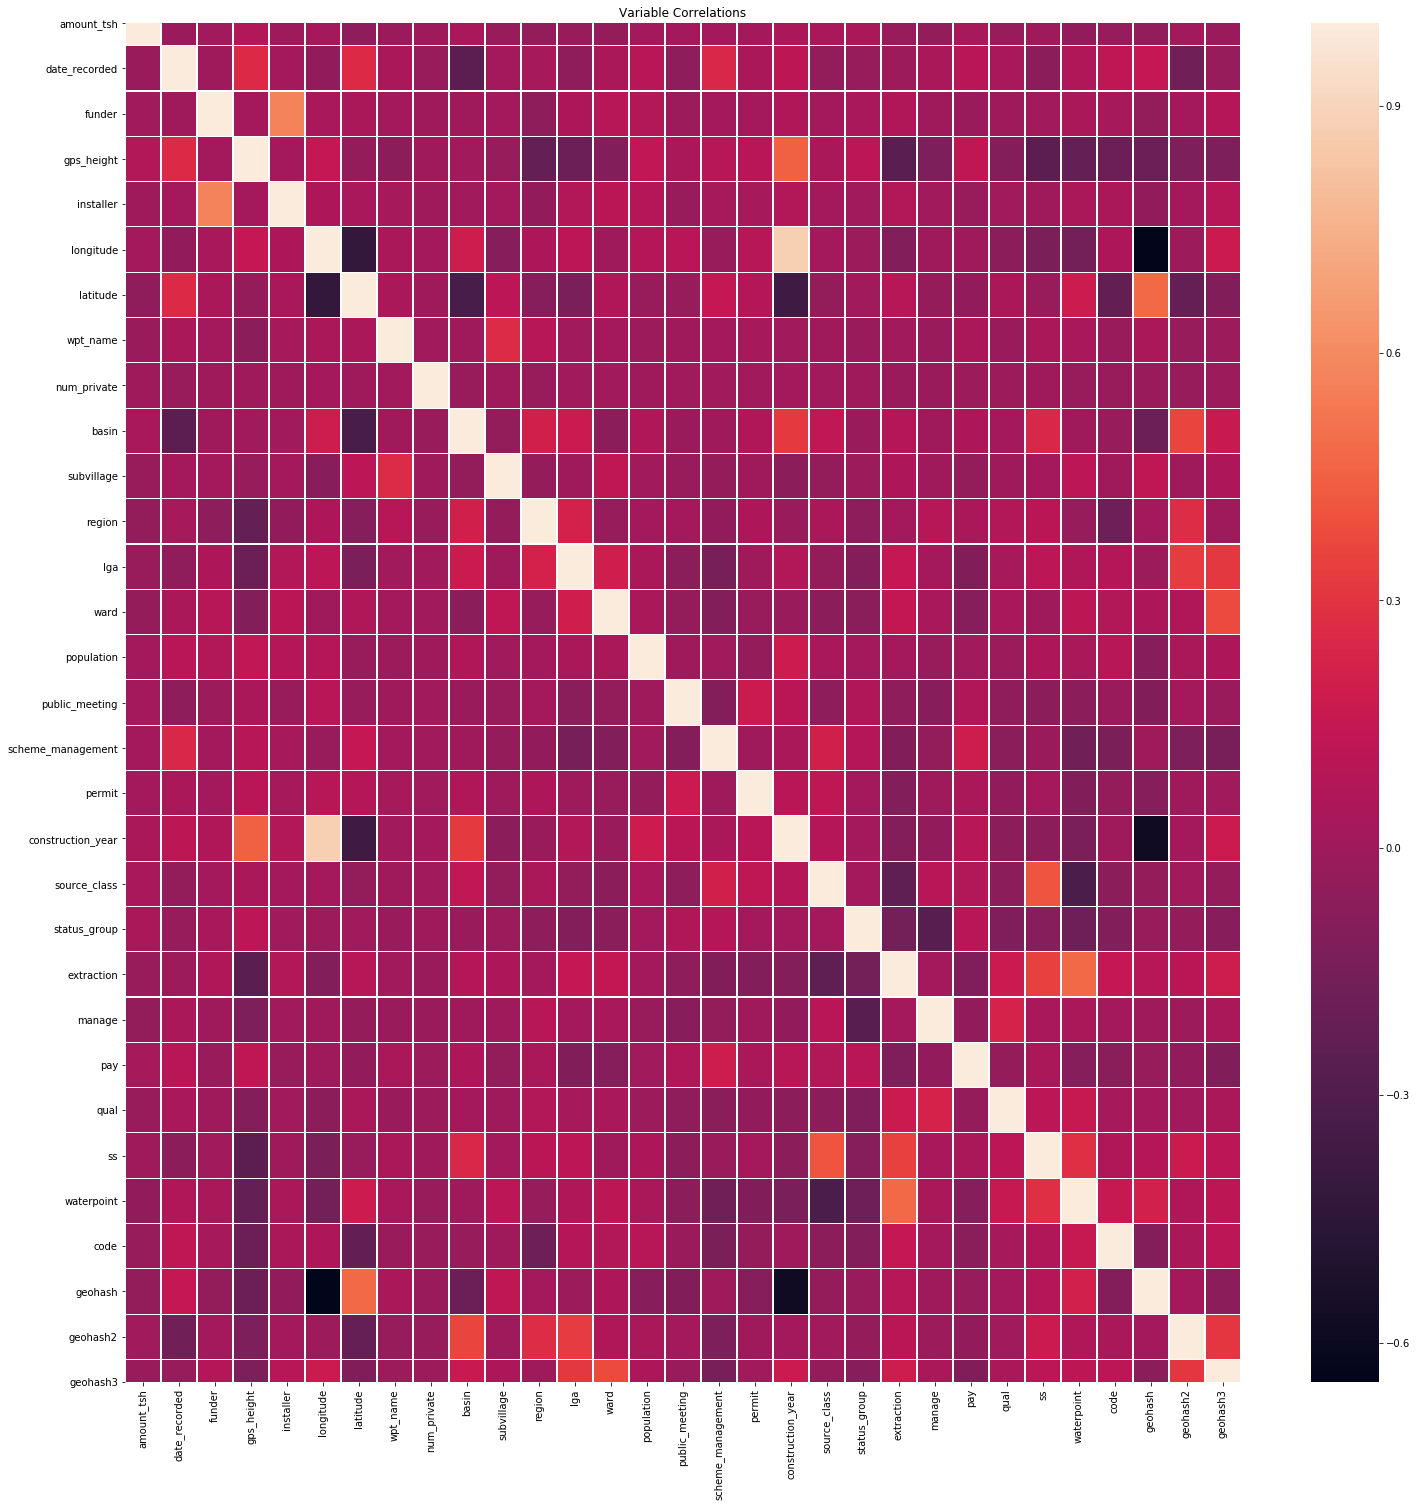

In [0]:
import seaborn as sns
correlations = train.corr()
fig, ax = plt.subplots(figsize=(25,25))
corr_heat = sns.heatmap(correlations, linewidths=0.125, ax=ax)
plt.title('Variable Correlations')

In [0]:
status_groups = train.status_group
train = train.drop('status_group', axis=1)

In [0]:
submit = pd.DataFrame({
        "id": test_id.values
        })

In [0]:
!pip3 -q install catboost
from catboost import CatBoostClassifier, Pool

In [0]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=30, random_state=2019, shuffle=True)

In [0]:
clf_1 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_2 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_3 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_4 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_5 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_6 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_7 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_8 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_9 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_10 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_11 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_12 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_13 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_14 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_15 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_16 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_17 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_18 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_19 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_20 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_21 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_22 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_23 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_24 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_25 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_26 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_27 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_28 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_29 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

clf_30 = CatBoostClassifier(iterations=10000, eval_metric='Accuracy', loss_function='MultiClass',
                         bootstrap_type='Bernoulli', boosting_type='Plain',
                         max_depth=8, random_state=1, od_type="Iter")

In [0]:
x = 1
for idx, (train_index, valid_index) in enumerate(kfold.split(train)):
  if x == 1:
    global clf_1
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_1.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_1 = clf_1.predict(test)
    submit['status_group_1'] = y_test_pred_1.ravel()
    print(clf_1.best_score_)
    clf_1.save_model('clf_1.hdf5')
    x+=1
    continue
  elif x == 2:
    global clf_2
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_2.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_2 = clf_2.predict(test)
    submit['status_group_2'] = y_test_pred_2.ravel()
    print(clf_2.best_score_)
    clf_2.save_model('clf_2.hdf5')
    x+=1
    continue
  elif x == 3:
    global clf_3
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_3.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_3 = clf_3.predict(test)
    submit['status_group_3'] = y_test_pred_3.ravel()
    print(clf_3.best_score_)
    clf_3.save_model('clf_3.hdf5')
    x+=1
    continue
  elif x == 4:
    global clf_4
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_4.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_4 = clf_4.predict(test)
    submit['status_group_4'] = y_test_pred_4.ravel()
    print(clf_4.best_score_)
    clf_4.save_model('clf_4.hdf5')
    x+=1
    continue
  elif x == 5:
    global clf_5
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_5.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_5 = clf_5.predict(test)
    submit['status_group_5'] = y_test_pred_5.ravel()
    print(clf_5.best_score_)
    clf_5.save_model('clf_5.hdf5')
    x+=1
    continue
  elif x == 6:
    global clf_6
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_6.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_6 = clf_6.predict(test)
    submit['status_group_6'] = y_test_pred_6.ravel()
    print(clf_6.best_score_)
    clf_6.save_model('clf_6.hdf5')
    x+=1
    continue
  elif x == 7:
    global clf_7
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_7.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_7 = clf_7.predict(test)
    submit['status_group_7'] = y_test_pred_7.ravel()
    print(clf_7.best_score_)
    clf_7.save_model('clf_7.hdf5')
    x+=1
    continue
  elif x == 8:
    global clf_8
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_8.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_8 = clf_8.predict(test)
    submit['status_group_8'] = y_test_pred_8.ravel()
    print(clf_8.best_score_)
    clf_8.save_model('clf_8.hdf5')
    x+=1
    continue
  elif x == 9:
    global clf_9
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_9.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_9 = clf_9.predict(test)
    submit['status_group_9'] = y_test_pred_9.ravel()
    print(clf_9.best_score_)
    clf_9.save_model('clf_9.hdf5')
    x+=1
    continue
  elif x == 10:
    global clf_10
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_10.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_10 = clf_10.predict(test)
    submit['status_group_10'] = y_test_pred_10.ravel()
    print(clf_10.best_score_)
    clf_10.save_model('clf_10.hdf5')
    x+=1
    continue
  elif x == 11:
    global clf_11
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_11.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_11 = clf_11.predict(test)
    submit['status_group_11'] = y_test_pred_11.ravel()
    print(clf_11.best_score_)
    clf_11.save_model('clf_11.hdf5')
    x+=1
    continue
  elif x == 12:
    global clf_12
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_12.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_12 = clf_12.predict(test)
    submit['status_group_12'] = y_test_pred_12.ravel()
    print(clf_12.best_score_)
    clf_12.save_model('clf_12.hdf5')
    x+=1
    continue
  elif x == 13:
    global clf_13
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_13.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_13 = clf_5.predict(test)
    submit['status_group_13'] = y_test_pred_13.ravel()
    print(clf_13.best_score_)
    clf_13.save_model('clf_13.hdf5')
    x+=1
    continue
  elif x == 14:
    global clf_14
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_14.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_14 = clf_14.predict(test)
    submit['status_group_14'] = y_test_pred_14.ravel()
    print(clf_14.best_score_)
    clf_14.save_model('clf_14.hdf5')
    x+=1
    continue
  elif x == 15:
    global clf_15
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_15.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_15 = clf_15.predict(test)
    submit['status_group_15'] = y_test_pred_15.ravel()
    print(clf_15.best_score_)
    clf_15.save_model('clf_15.hdf5')
    x+=1
    continue
  elif x == 16:
    global clf_16
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_16.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_16 = clf_16.predict(test)
    submit['status_group_16'] = y_test_pred_16.ravel()
    print(clf_16.best_score_)
    clf_16.save_model('clf_16.hdf5')
    x+=1
    continue
  elif x == 17:
    global clf_17
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_17.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_17 = clf_17.predict(test)
    submit['status_group_17'] = y_test_pred_17.ravel()
    print(clf_17.best_score_)
    clf_17.save_model('clf_17.hdf5')
    x+=1
    continue
  elif x == 18:
    global clf_18
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_18.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_18 = clf_18.predict(test)
    submit['status_group_18'] = y_test_pred_18.ravel()
    print(clf_18.best_score_)
    clf_18.save_model('clf_18.hdf5')
    x+=1
    continue
  elif x == 19:
    global clf_19
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_19.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_19 = clf_19.predict(test)
    submit['status_group_19'] = y_test_pred_19.ravel()
    print(clf_19.best_score_)
    clf_19.save_model('clf_19.hdf5')
    x+=1
    continue
  elif x == 20:
    global clf_20
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_20.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_20 = clf_20.predict(test)
    submit['status_group_20'] = y_test_pred_20.ravel()
    print(clf_20.best_score_)
    clf_20.save_model('clf_20.hdf5')
    x+=1
    continue
  elif x == 21:
    global clf_21
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_21.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_21 = clf_21.predict(test)
    submit['status_group_21'] = y_test_pred_21.ravel()
    print(clf_21.best_score_)
    clf_21.save_model('clf_21.hdf5')
    x+=1
    continue
  elif x == 22:
    global clf_22
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_22.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_22 = clf_22.predict(test)
    submit['status_group_22'] = y_test_pred_22.ravel()
    print(clf_22.best_score_)
    clf_22.save_model('clf_22.hdf5')
    x+=1
    continue
  elif x == 23:
    global clf_23
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_23.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_23 = clf_23.predict(test)
    submit['status_group_23'] = y_test_pred_23.ravel()
    print(clf_23.best_score_)
    clf_23.save_model('clf_23.hdf5')
    x+=1
    continue
  elif x == 24:
    global clf_24
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_24.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_24 = clf_24.predict(test)
    submit['status_group_24'] = y_test_pred_24.ravel()
    print(clf_24.best_score_)
    clf_24.save_model('clf_24.hdf5')
    x+=1
    continue
  elif x == 25:
    global clf_25
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_25.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_25 = clf_25.predict(test)
    submit['status_group_25'] = y_test_pred_25.ravel()
    print(clf_25.best_score_)
    clf_25.save_model('clf_25.hdf5')
    x+=1
    continue
  elif x == 26:
    global clf_26
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_26.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_26 = clf_26.predict(test)
    submit['status_group_26'] = y_test_pred_26.ravel()
    print(clf_26.best_score_)
    clf_26.save_model('clf_26.hdf5')
    x+=1
    continue
  elif x == 27:
    global clf_27
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_27.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_27 = clf_27.predict(test)
    submit['status_group_27'] = y_test_pred_27.ravel()
    print(clf_25.best_score_)
    clf_27.save_model('clf_27.hdf5')
    x+=1
    continue
  elif x == 28:
    global clf_28
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_28.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_28 = clf_28.predict(test)
    submit['status_group_28'] = y_test_pred_28.ravel()
    print(clf_28.best_score_)
    clf_28.save_model('clf_28.hdf5')
    x+=1
    continue
  elif x == 29:
    global clf_29
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_29.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_29 = clf_29.predict(test)
    submit['status_group_29'] = y_test_pred_29.ravel()
    print(clf_29.best_score_)
    clf_29.save_model('clf_29.hdf5')
    x+=1
    continue
  elif x == 30:
    global clf_30
    X_train, X_valid, y_train, y_valid = train.iloc[train_index,:], train.iloc[valid_index,:], target.iloc[train_index], target.iloc[valid_index]
    cat_train = Pool(X_train, y_train)
    cat_valid = Pool(X_valid, y_valid)
    print("\nNEW FOLD :", idx+1)
    print("Train samples:", len(X_train))
    clf_30.fit(cat_train, eval_set=cat_valid, early_stopping_rounds=500, verbose=500, use_best_model=True, plot=True)
    y_test_pred_30 = clf_30.predict(test)
    submit['status_group_30'] = y_test_pred_30.ravel()
    print(clf_30.best_score_)
    clf_30.save_model('clf_30.hdf5')
    x+=1
    continue
  else:
    print('Training Complete')
    break

In [0]:
submit.head(25)

,id,status_group_1,status_group_2,status_group_3,status_group_4,status_group_5,status_group_6,status_group_7,status_group_8,status_group_9,status_group_10,status_group_11,status_group_12,status_group_13,status_group_14,status_group_15,status_group_16,status_group_17,status_group_18,status_group_19,status_group_20,status_group_21
0,50785,1.0,1.0,-1.0,-1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,51630,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,17168,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,45559,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,49871,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,52449,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,24806,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,28965,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,36301,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,54122,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


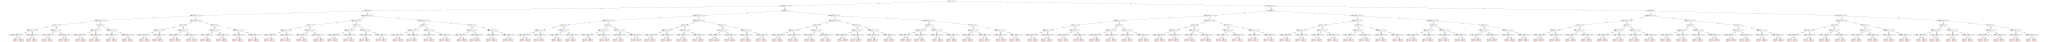

In [0]:
clf_30.plot_tree(tree_idx=123, pool=cat_train)

In [0]:
feature_stuff_1 = dict(zip(clf_1.feature_names_, clf_1.feature_importances_))
feature_stuff_2 = dict(zip(clf_2.feature_names_, clf_2.feature_importances_))
feature_stuff_3 = dict(zip(clf_3.feature_names_, clf_3.feature_importances_))
feature_stuff_4 = dict(zip(clf_4.feature_names_, clf_4.feature_importances_))
feature_stuff_5 = dict(zip(clf_5.feature_names_, clf_5.feature_importances_))
feature_stuff_6 = dict(zip(clf_6.feature_names_, clf_6.feature_importances_))
feature_stuff_7 = dict(zip(clf_7.feature_names_, clf_7.feature_importances_))
feature_stuff_8 = dict(zip(clf_8.feature_names_, clf_8.feature_importances_))
feature_stuff_9 = dict(zip(clf_9.feature_names_, clf_9.feature_importances_))
feature_stuff_10 = dict(zip(clf_10.feature_names_, clf_10.feature_importances_))
feature_stuff_11 = dict(zip(clf_11.feature_names_, clf_11.feature_importances_))
feature_stuff_12 = dict(zip(clf_12.feature_names_, clf_12.feature_importances_))
feature_stuff_13 = dict(zip(clf_13.feature_names_, clf_13.feature_importances_))
feature_stuff_14 = dict(zip(clf_14.feature_names_, clf_14.feature_importances_))
feature_stuff_15 = dict(zip(clf_15.feature_names_, clf_15.feature_importances_))
feature_stuff_16 = dict(zip(clf_16.feature_names_, clf_16.feature_importances_))
feature_stuff_17 = dict(zip(clf_17.feature_names_, clf_17.feature_importances_))
feature_stuff_18 = dict(zip(clf_18.feature_names_, clf_18.feature_importances_))
feature_stuff_19 = dict(zip(clf_19.feature_names_, clf_19.feature_importances_))
feature_stuff_20 = dict(zip(clf_20.feature_names_, clf_20.feature_importances_))
feature_stuff_21 = dict(zip(clf_21.feature_names_, clf_21.feature_importances_))
feature_stuff_22 = dict(zip(clf_22.feature_names_, clf_22.feature_importances_))
feature_stuff_23 = dict(zip(clf_23.feature_names_, clf_23.feature_importances_))
feature_stuff_24 = dict(zip(clf_24.feature_names_, clf_24.feature_importances_))
feature_stuff_25 = dict(zip(clf_25.feature_names_, clf_25.feature_importances_))
feature_stuff_26 = dict(zip(clf_26.feature_names_, clf_26.feature_importances_))
feature_stuff_27 = dict(zip(clf_27.feature_names_, clf_27.feature_importances_))
feature_stuff_28 = dict(zip(clf_28.feature_names_, clf_28.feature_importances_))
feature_stuff_29 = dict(zip(clf_29.feature_names_, clf_28.feature_importances_))
feature_stuff_30 = dict(zip(clf_30.feature_names_, clf_28.feature_importances_))


print(feature_stuff_1)
print(feature_stuff_2)
print(feature_stuff_3)
print(feature_stuff_4)
print(feature_stuff_5)
print(feature_stuff_6)
print(feature_stuff_7)
print(feature_stuff_8)
print(feature_stuff_9)
print(feature_stuff_10)
print(feature_stuff_11)
print(feature_stuff_12)
print(feature_stuff_13)
print(feature_stuff_14)
print(feature_stuff_15)
print(feature_stuff_16)
print(feature_stuff_17)
print(feature_stuff_18)
print(feature_stuff_19)
print(feature_stuff_20)
print(feature_stuff_21)
print(feature_stuff_22)
print(feature_stuff_23)
print(feature_stuff_24)
print(feature_stuff_25)
print(feature_stuff_26)
print(feature_stuff_27)
print(feature_stuff_28)
print(feature_stuff_29)
print(feature_stuff_30)

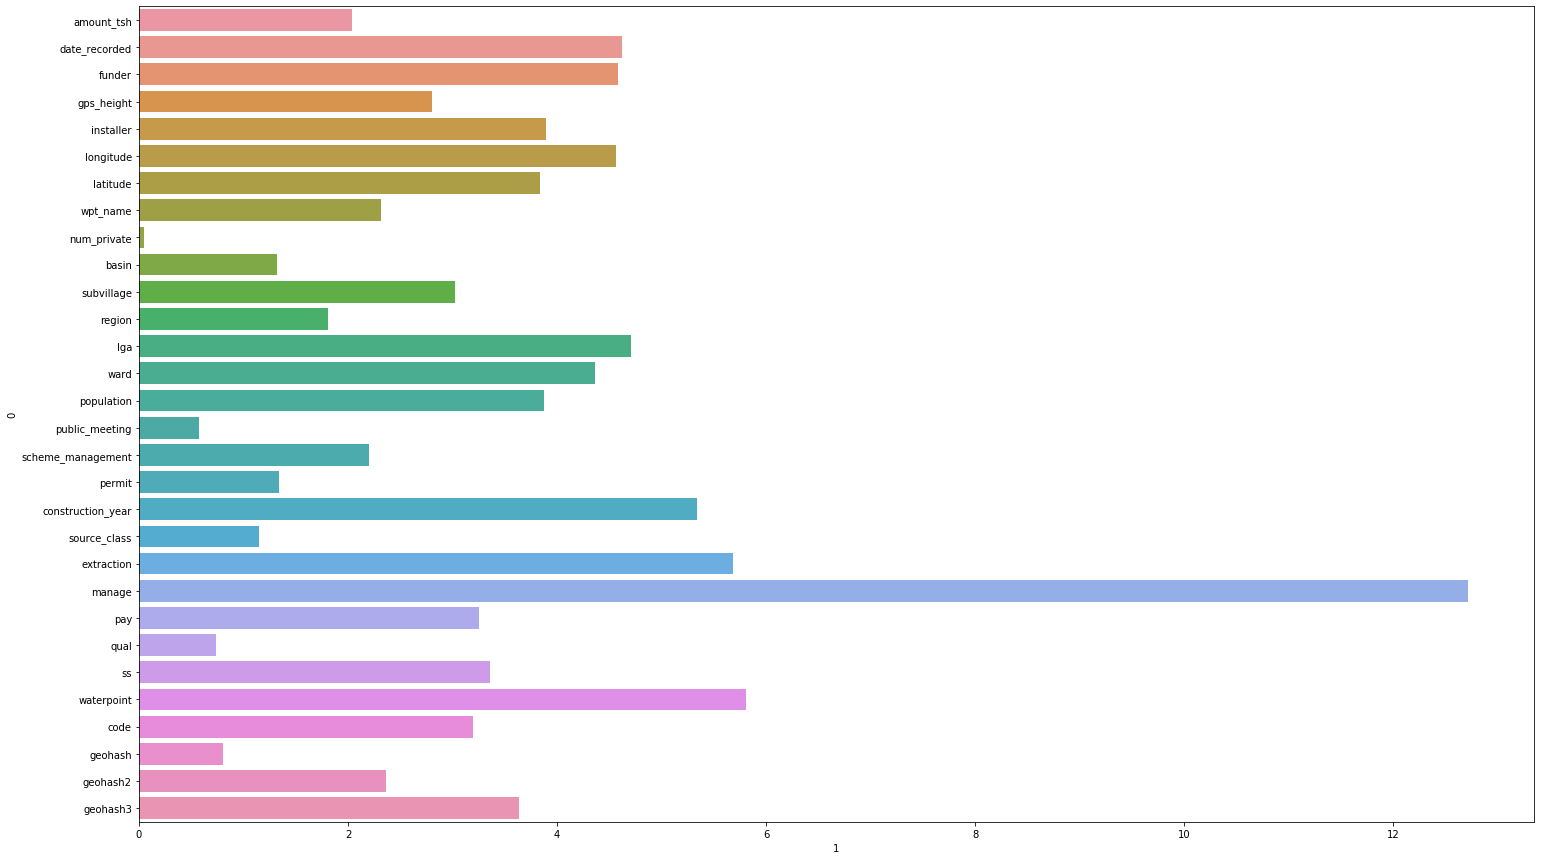

In [0]:
feature_stuff1 = pd.DataFrame(zip(clf_1.feature_names_, clf_1.feature_importances_))
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff1, label="Total")

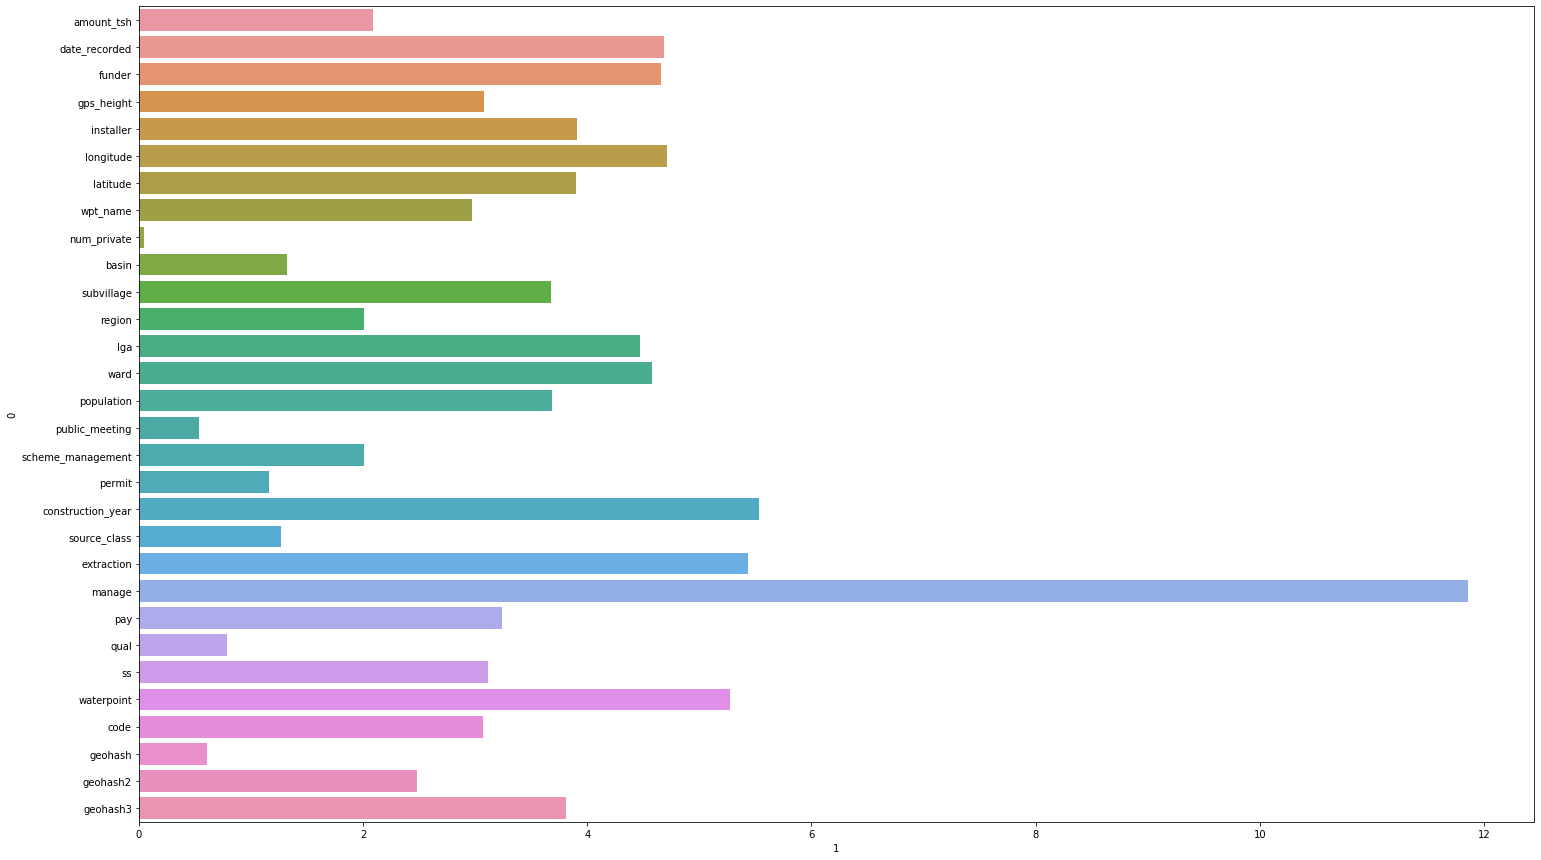

In [0]:
feature_stuff2 = pd.DataFrame(zip(clf_2.feature_names_, clf_2.feature_importances_))
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff2, label="Total")

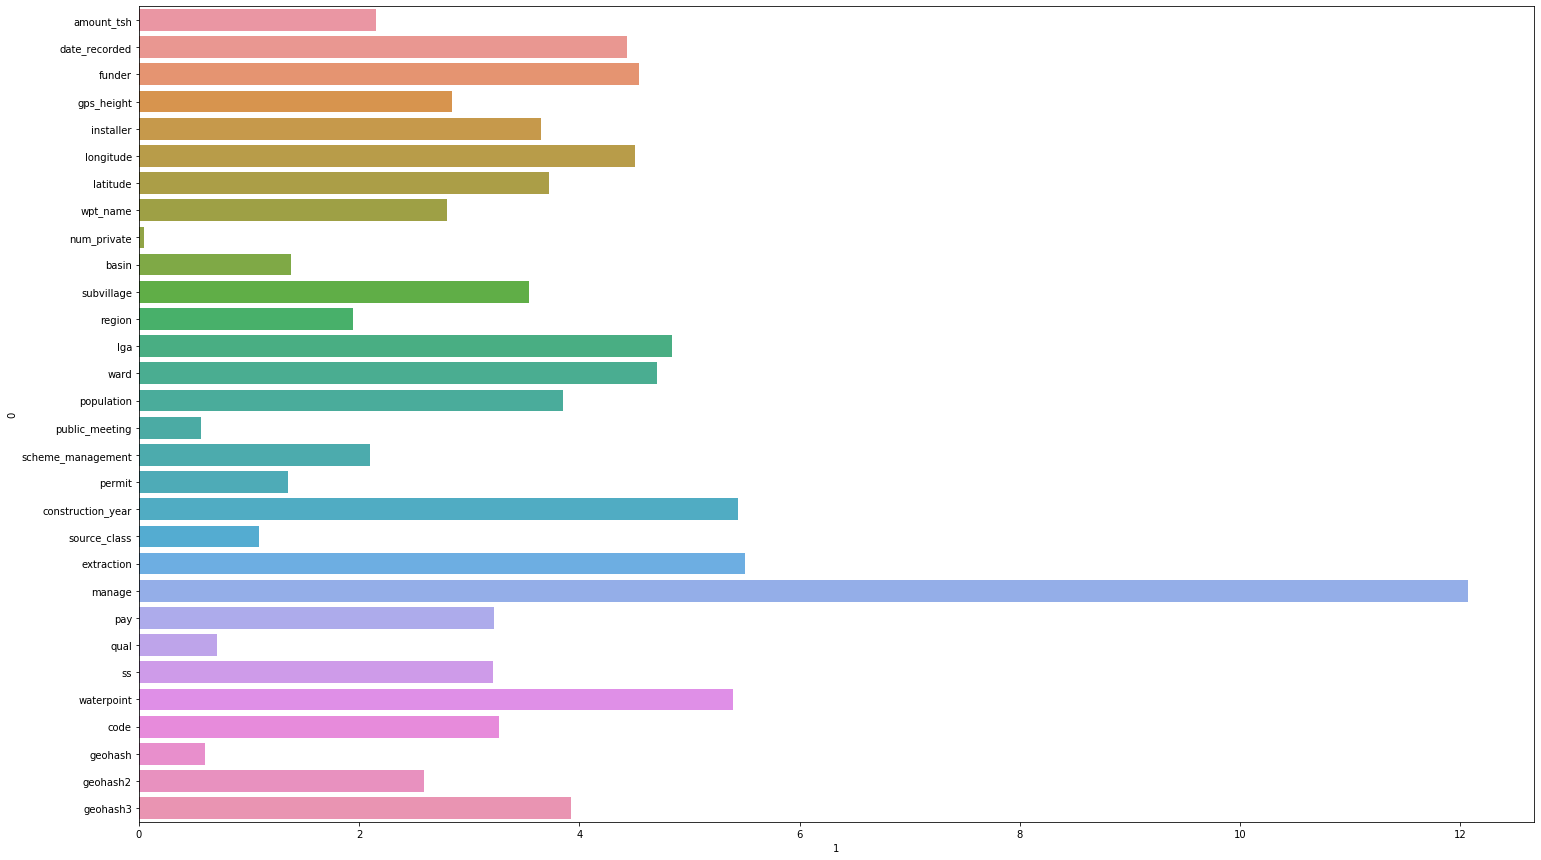

In [0]:
feature_stuff3 = pd.DataFrame(zip(clf_3.feature_names_, clf_3.feature_importances_))
ax, f = plt.subplots(figsize=(25, 15))
sns.barplot(x=1, y=0, data=feature_stuff3, label="Total")

In [0]:
import statistics

status = []
for i in range(0, len(submit)):
  listy = [] 
  for j in submit.columns[1:]: # removes id column
    listy.append(submit[j][i]) # appends each column's i index to list
  try:
    mode = statistics.mode(listy)
  except:
    avg = sum(listy)/len(listy)
    if avg<-0.175:
      mode = -1
    elif avg>0.175:
      mode =  1
    else:
      mode = 0
  status.append(mode)

In [0]:
submission = pd.DataFrame({
    "id": test_id.values,
    "status_group": status
})
submission.status_group = submission.status_group.astype(int)
del status, listy, mode

In [0]:
submission.head(25)

,id,status_group
0,50785,1
1,51630,1
2,17168,1
3,45559,-1
4,49871,1
5,52449,1
6,24806,-1
7,28965,-1
8,36301,-1
9,54122,1


Text(0.5, 1.0, 'TRAIN: # of Buildings for each Damage Grade')

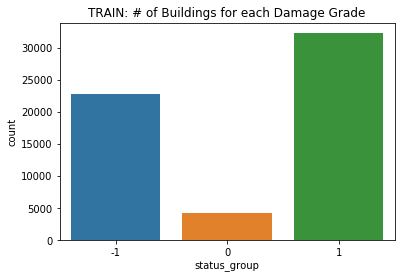

In [0]:
sns.countplot(status_groups)
plt.title('TRAIN: # of Buildings for each Damage Grade')

Text(0.5, 1.0, 'PREDICTIONS: # of Buildings for each Damage Grade')

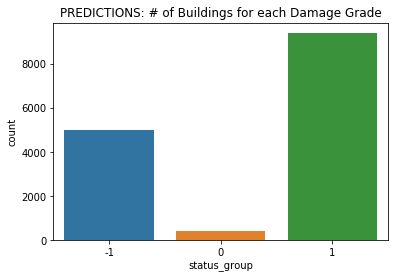

In [0]:
sns.countplot(submission.status_group)
plt.title('PREDICTIONS: # of Buildings for each Damage Grade')

In [0]:
submission.status_group = submission.status_group.map({1: "functional", -1: "non functional", 0: "functional needs repair"})
submission.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('PUMPITUP_SUBMISSION_9.csv', index=False)
from google.colab import files
files.download('PUMPITUP_SUBMISSION_9.csv')